In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Install libraries

```bash
conda create -n edu4 python=3.11 jupyter matplotlib
```

```bash 
! pip install -U -r requirements.txt
```

```bash
! pip install -U numpy
! pip install -U scikit-learn
```

## Update repository

In [2]:
# ! git pull

## Add import path

In [3]:
import os
import sys
import gc

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
del module_path

## Organize imports

In [7]:
from datasets import load_dataset

In [8]:
import multiprocessing
from pathlib import Path

In [9]:
from tqdm import tqdm

In [10]:
import seaborn as sns

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
import plotly.express as px

In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [14]:
import os

In [15]:
import PIL
from clipscope import ConfiguredViT, TopKSAE

In [16]:
from src.lattmc.fca.utils import *
from src.lattmc.fca.data_utils import *
from src.lattmc.fca.image_utils import *
from src.lattmc.fca.models import *
from src.lattmc.fca.fca_utils import *
from src.lattmc.fca.image_gens import *

#### Number of CPU cores

In [17]:
workers = multiprocessing.cpu_count()
workers

12

In [18]:
SEED = 2024

In [19]:
# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: mps


## Initialize Path

In [20]:
PATH = Path('data')
checkpoint_dir = PATH / 'saes'
checkpoint_dir.mkdir(exist_ok=True, parents=True)
checkpoint_path1 = checkpoint_dir / 'best-checkpoint-v1.ckpt'
checkpoint_path2 = checkpoint_dir / 'best-checkpoint.ckpt'
fca_path = checkpoint_dir / 'vit_scope_res20_900034560_imagenette_val.joblib'

image_dir = PATH / 'images'
image_path = image_dir / '1024.png'

## Initialize simple dataset

In [21]:
# transform = None

# Load CIFAR-10 test dataset (download if needed)
# train_dataset = datasets.Imagenette(
#     root="./data", 
#     split='train',
#     size='160px',
#     # transform=transform, 
#     download=True
# )
val_dataset = datasets.Imagenette(
    root="./data", 
    split='val',
    size='160px',
    # transform=transform, 
    download=True
)
# Use a subset (e.g., 1000 images) to keep dataset small (<10,000 images)
# subset_size = 1000
# subset = Subset(dataset, range(subset_size))
# dataloader = DataLoader(subset, batch_size=32, shuffle=False)

## Initialize model

In [22]:
layer = 20
resid = 'resid'

In [23]:
filename_in_hf_repo = f'{layer}_{resid}/900034560.pt'
sae = TopKSAE.from_pretrained(checkpoint=filename_in_hf_repo, device=device)

locations = [(layer, resid)]
transformer = ConfiguredViT(locations, device=device)

In [24]:
transformer

In [29]:
sae

TopKSAE(
  (activation): ReLU()
)

In [32]:
?? sae

Signature:        sae(*args, **kwargs)
Type:            TopKSAE
String form:    
TopKSAE(
  (activation): ReLU()
)
File:            ~/anaconda3/envs/sae1/lib/python3.12/site-packages/clipscope/sae.py
Source:         
class TopKSAE(SAE):
    @classmethod
    def from_pretrained(cls, checkpoint, repo_id=REPO_ID, device='cuda'):
        checkpoint = cls._download(checkpoint=checkpoint, repo_id=repo_id, device=device)

        sae = cls(k=checkpoint['k'], n_features=checkpoint['n_features'], d_in=checkpoint['d_in'], device=device)
        sae.load_state_dict(checkpoint['model_state_dict'])
                                         
        return sae

    def __init__(self, k, *args, **kwargs):
        super(TopKSAE, self).__init__(*args, **kwargs)
        self.k = k
        self.activation_fn = None

    def _encode(self, x):
        return encode_topk(x, self.k)

    def _decode(self, topk, dec):
        return eagre_decode(topk, dec)
Class docstring:
Base class for all neural network mod

In [33]:
sae.state_dict()

OrderedDict([('pre_b',
              tensor([ 0.2531, -0.4311, -0.1998,  ..., -0.2526, -0.0732, -0.1745],
                     device='mps:0')),
             ('enc',
              tensor([[ 0.0114,  0.0129, -0.0247,  ..., -0.0014,  0.0053,  0.0336],
                      [ 0.0143,  0.0134,  0.0111,  ..., -0.0245,  0.0363,  0.0027],
                      [-0.0352, -0.0447,  0.0346,  ..., -0.0384, -0.0082,  0.0363],
                      ...,
                      [-0.0049, -0.0037, -0.0357,  ..., -0.0153, -0.0164,  0.0304],
                      [-0.0070,  0.0147,  0.0019,  ...,  0.0147, -0.0246, -0.0748],
                      [-0.0342, -0.0097,  0.0282,  ...,  0.0022, -0.0412, -0.0245]],
                     device='mps:0')),
             ('dec',
              tensor([[-0.0004, -0.0038, -0.0406,  ...,  0.0142, -0.0025, -0.0056],
                      [ 0.0114,  0.0283, -0.0383,  ..., -0.0038,  0.0304,  0.0264],
                      [-0.0235,  0.0239,  0.0232,  ..., -0.0213,  0.0099, 

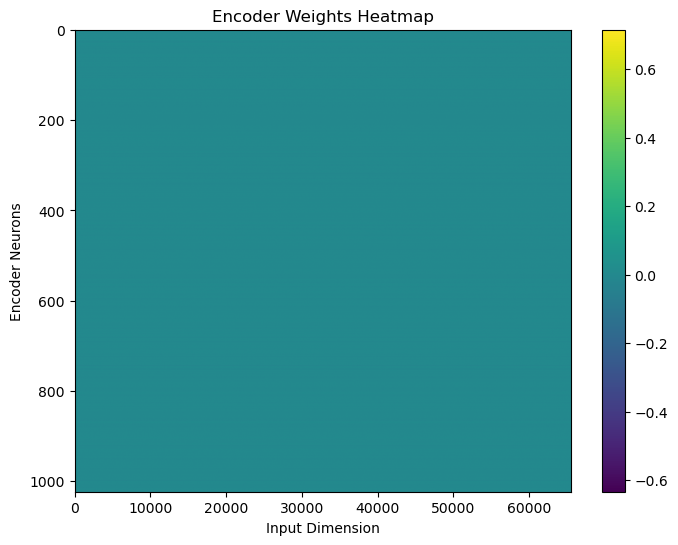

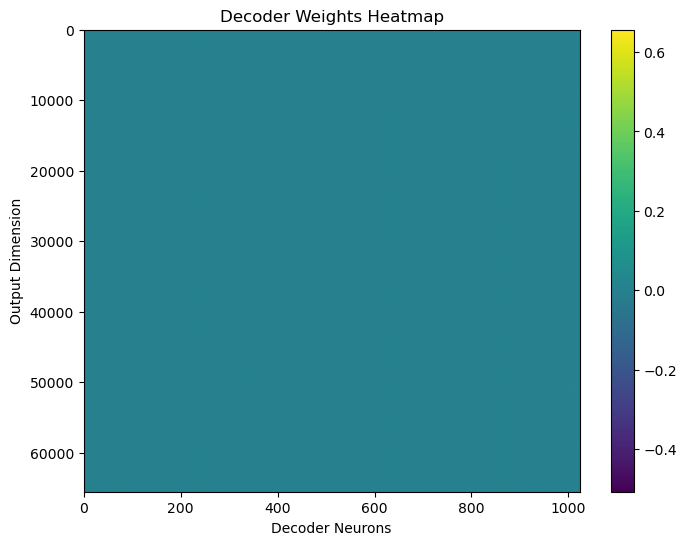

In [34]:
# Assuming the TopKSAE model has attributes 'encoder' and 'decoder'.
# (Depending on the implementation, these might be linear layers or stacks of layers.)

# For illustration, we extract the weight matrices from the first (or only) layer of the encoder and decoder.
# encoder_layer = sae._encoder  # Adjust if your encoder is a sequence of layers
# decoder_layer = sae.decoder  # Likewise for decoder

# If these are nn.Linear layers, their weight shapes will be (out_features, in_features)
encoder_weights = sae.state_dict()['enc'].detach().cpu().numpy()
decoder_weights = sae.state_dict()['dec'].detach().cpu().numpy()

# Option 1: Visualize the entire weight matrix as a heatmap.
plt.figure(figsize=(8, 6))
plt.imshow(encoder_weights, cmap="viridis", aspect="auto")
plt.title("Encoder Weights Heatmap")
plt.xlabel("Input Dimension")
plt.ylabel("Encoder Neurons")
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(decoder_weights, cmap="viridis", aspect="auto")
plt.title("Decoder Weights Heatmap")
plt.xlabel("Decoder Neurons")
plt.ylabel("Output Dimension")
plt.colorbar()
plt.show()

# Option 2: If your weights can be reshaped into a 2D "filter" (e.g. if the input is an image),
# you can try to reshape and visualize individual filters. For example, if the encoder weight for one neuron
# represents a flattened 2D patch (say 8x8):
filter_size = 8  # adjust as appropriate if encoder_weights.shape[1] == 64, for instance
if encoder_weights.shape[1] == filter_size * filter_size:
    num_neurons = encoder_weights.shape[0]
    fig, axes = plt.subplots(1, num_neurons, figsize=(num_neurons * 1.2, 1.5))
    for i, ax in enumerate(axes):
        filter_img = encoder_weights[i].reshape(filter_size, filter_size)
        ax.imshow(filter_img, cmap="gray")
        ax.axis("off")
    plt.suptitle("Reshaped Encoder Filters")
    plt.show()

In [35]:
gc.collect()

11386

In [ ]:
def topK(a, k):
    return np.argsort(a)[-k:][::-1]

In [ ]:
def vec_i_j(v_sm, indices, values):
    v_m = np.zeros_like(v_sm)
    v_m[indices] = values

    return v_m

In [ ]:
def show_images(indices, ds):
    for idx in indices:
        plt.imshow(ds[idx][0])
        plt.show()

In [ ]:
def sim_vecs(u, U, match=16):
    with(tqdm(U)) as pV:
        sim_vecs = [
            (idx, v) for idx, v in enumerate(pV) if (
                np.intersect1d(np.nonzero(v), np.nonzero(u)).shape[0] > match
            )
        ]

    return sim_vecs

In [ ]:
if fca_path.exists():
    fca = FCA.load(fca_path)
    V = fca.V
else:
    V = []
    # Process images in batches
    with(tqdm(val_dataset)) as datap:
        for batch_idx, (image, label) in enumerate(datap):
            activations = transformer.all_activations(image)[locations[0]]  # shape: (B, token_count, hidden_dim)
            cls_activations = activations[:, 0]  # (B, hidden_dim)
            
            # Forward pass through the sparse autoencoder
            output = sae.forward_verbose(cls_activations)
            v = output['latent'][0].to('cpu').detach().numpy()
            V.append(v)
    fca = FCA(V)
    fca.save(fca_path)

In [ ]:
len(V), V[0].shape, V[0]

In [ ]:
v_x = V[-2]

In [ ]:
val_dataset[-2][1]

In [ ]:
v_y = V[-1000]

In [ ]:
val_dataset[-1000][1]

In [ ]:
val_dataset.classes

In [ ]:
np.nonzero(v_x), np.max(v_x), np.argmax(v_x), v_x[np.argmax(v_x)]

In [ ]:
V_sim1 = sim_vecs(v_x, V, match=16)

In [ ]:
V_sim2 = sim_vecs(v_y, V, match=16)

In [ ]:
len(V_sim1), len(V_sim2)

In [ ]:
v_A = find_v_A(V, np.array([v_s[0] for v_s in V_sim1[2:48]]))

In [ ]:
k = 12
idx_cm = np.nonzero(v_x)
for v_s in V_sim1:
    print(f'{topK(v_s[1], k)} {np.argmax(v_s[1])} {v_s[1][topK(v_s[1], k)]} {np.max(v_s[1])}')
    print(f'{np.intersect1d(np.nonzero(v_s[1]), np.nonzero(v_x))}\n')
    idx_cm = np.intersect1d(idx_cm, np.nonzero(v_s[1]))

In [ ]:
idx_cm

In [ ]:
idxs_1 = [43191, 7336, 53186, 53808] 
vals_1 = [3, 3, 3, 3]

In [ ]:
k = 12
idx_cm = np.nonzero(v_x)
for v_s in V_sim2:
    print(f'{topK(v_s[1], k)} {np.argmax(v_s[1])} {v_s[1][topK(v_s[1], k)]} {np.max(v_s[1])}')
    print(f'{np.intersect1d(np.nonzero(v_s[1]), np.nonzero(v_x))}\n')
    idx_cm = np.intersect1d(idx_cm, np.nonzero(v_s[1]))

In [ ]:
idx_cm

In [ ]:
idxs_2 = [43191, 7336, 53186, 53808] 
vals_2 = [2, 2, 2, 2]

In [ ]:
len(V_sim1), len(V_sim2)

In [ ]:
plt.imshow(val_dataset[V_sim1[2][0]][0])
plt.show()

In [ ]:
v_i = vec_i_j(v_x, idxs_1, vals_1)
v_j = vec_i_j(v_x, idxs_1, vals_1)

In [ ]:
v_i = vec_i_j(v_x, [30176], [1.2])
v_j = vec_i_j(v_x, [28187], [1.2])

In [ ]:
# 31720 28187 30176 15519  7995   993

In [ ]:
v_i[31720] = 1.2
v_j[28187] = 1.2

In [ ]:
v_p = vec_i_j(v_x, idxs_1, vals_1)
v_q = vec_i_j(v_x, idxs_1, vals_1)

In [ ]:
v_p[30176] = 2.
v_q[15519] = 2.

In [ ]:
v_t = vec_i_j(v_x, idxs_1, vals_1)
v_s = vec_i_j(v_x, idxs_1, vals_1)

In [ ]:
v_t[7995] = 1.2
v_s[993] = 1.2

In [ ]:
concept_i = fca.G_FG(v_i)
concept_i

In [ ]:
show_images(concept_i.A[:10], val_dataset)

In [ ]:
concept_j = fca.G_FG(v_j)
concept_j

In [ ]:
show_images(concept_j.A[:10], val_dataset)

In [ ]:
concept_i_j = concept_i & concept_j
concept_i_j

In [ ]:
show_images(concept_i_j.A[:10], val_dataset)

In [ ]:
concept_p = fca.G_FG(v_p)
concept_p

In [ ]:
concept_q = fca.G_FG(v_q)
concept_q

In [ ]:
concept_p_q = concept_p & concept_q
concept_p_q

In [ ]:
show_images(concept_p_q.A, val_dataset)

In [ ]:
concept_t = fca.G_FG(v_t)
concept_t

In [ ]:
concept_s = fca.G_FG(v_s)
concept_s

In [ ]:
concept_t_s = concept_t & concept_s
concept_t_s

In [ ]:
show_images(concept_t_s.A[:10], val_dataset)

In [ ]:
v_a = vec_i_j(v_y, idxs_2, vals_2)
v_b = vec_i_j(v_y, idxs_2, vals_2)

In [ ]:
# 28187 30176 15519  7995 50928 31720

In [ ]:
v_a[28187] = 1.2
v_b[30176] = 1.2

In [ ]:
concept_a = fca.G_FG(v_a)
concept_a

In [ ]:
show_images(concept_a.A[:10], val_dataset)

In [ ]:
concept_b = fca.G_FG(v_b)
concept_b

In [ ]:
show_images(concept_b.A[:10], val_dataset)

In [ ]:
concept_a_b = concept_a & concept_b
concept_a_b

In [ ]:
show_images(concept_a_b.A[:10], val_dataset)

In [ ]:
v_c = vec_i_j(v_y, idxs_2, vals_2)
v_d = vec_i_j(v_y, idxs_2, vals_2)
v_e = vec_i_j(v_y, idxs_2, vals_2)
v_f = vec_i_j(v_y, idxs_2, vals_2)

In [ ]:
v_c[26494] = 1.
v_d[8588] = 1
v_e[36155] = 1
v_f[19359] = 1

In [ ]:
concept_c = fca.G_FG(v_c)
concept_c

In [ ]:
concept_d = fca.G_FG(v_d)
concept_d

In [ ]:
concept_e = fca.G_FG(v_e)
concept_e

In [ ]:
concept_f = fca.G_FG(v_f)
concept_f

In [ ]:
concept_c_d = concept_a & concept_b
concept_c_d

In [ ]:
concept_c_d_e = concept_a & concept_b & concept_e
concept_c_d_e

In [ ]:
concept_c_d_e_f = concept_a & concept_b & concept_e & concept_f
concept_c_d_e_f

In [ ]:
show_images(concept_c_d.A, val_dataset)

In [ ]:
show_images(concept_c_d_e.A, val_dataset)

In [ ]:
show_images(concept_c_d_e_f.A, val_dataset)